In [1]:
import numpy as np
#from sklearn.metrics import jaccard_similarity_score

In [2]:
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
from sklearn import preprocessing

In [4]:
df = pd.read_csv("data/travel_data.csv")

In [5]:
df = df.replace(-1.0, np.nan)
df = df.dropna(how="any")

In [6]:
df.head()

,UserID,ItemID,Rating,UserState,UserTimeZone,ItemCity,ItemState,ItemTimeZone,TripType
0,5C28F393B23BB894523AE7126A7AE445,219668,5,AK,AK,GREENSBORO,NC,EASTERN,SOLO
1,3FA27F6E8AC712A82C69C4EDD8B912CC,223860,5,AK,AK,PHOENIX,AZ,MOUNTAIN,SOLO
2,B99CFBB5411EDC8881D13B7A4B313ADA,75680,5,AK,AK,ANAHEIM,CA,PACIFIC,FAMILY
3,3FA27F6E8AC712A82C69C4EDD8B912CC,224783,5,AK,AK,SEATTLE,WA,PACIFIC,SOLO
4,7CEFF5C32BA1F3B186E7838C7D3FE25E,222984,5,AK,AK,MIAMI,MI,EASTERN,COUPLES


In [7]:
le_userstate = preprocessing.LabelEncoder()
le_usertimezone = preprocessing.LabelEncoder()
le_itemcity = preprocessing.LabelEncoder()
le_itemstate = preprocessing.LabelEncoder()
le_itemtimezone = preprocessing.LabelEncoder()
le_triptype = preprocessing.LabelEncoder()

In [8]:
le_userstate.fit(df.UserState.unique().tolist())
le_usertimezone.fit(df.UserTimeZone.unique().tolist())
le_itemcity.fit(df.ItemCity.unique().tolist())
le_itemstate.fit(df.ItemState.unique().tolist())
le_itemtimezone.fit(df.ItemTimeZone.unique().tolist())
le_triptype.fit(df.TripType.unique().tolist())

LabelEncoder()

In [9]:
df['UserState'] = le_userstate.transform(df.UserState)

In [10]:
df['UserTimeZone'] = le_usertimezone.transform(df.UserTimeZone)
df['ItemCity'] = le_itemcity.transform(df.ItemCity)
df['ItemState'] = le_itemstate.transform(df.ItemState)
df['ItemTimeZone'] = le_itemtimezone.transform(df.ItemTimeZone)
df['TripType'] = le_triptype.transform(df.TripType)

In [11]:
df.head()

,UserID,ItemID,Rating,UserState,UserTimeZone,ItemCity,ItemState,ItemTimeZone,TripType
0,5C28F393B23BB894523AE7126A7AE445,219668,5,0,0,37,16,1,4
1,3FA27F6E8AC712A82C69C4EDD8B912CC,223860,5,0,0,71,0,2,4
2,B99CFBB5411EDC8881D13B7A4B313ADA,75680,5,0,0,1,1,3,2
3,3FA27F6E8AC712A82C69C4EDD8B912CC,224783,5,0,0,92,29,3,4
4,7CEFF5C32BA1F3B186E7838C7D3FE25E,222984,5,0,0,57,13,1,1


In [12]:
## CONSTANTS ASSUMPTION
columns = df.columns.tolist()
columns.remove("Rating")
columns.append("Rating")
df = df[columns]
# X = df[columns[2:-1]]
# y = df[columns[-1:]]
# df = df.reset_index(drop=True)

In [13]:
df.head()

,UserID,ItemID,UserState,UserTimeZone,ItemCity,ItemState,ItemTimeZone,TripType,Rating
0,5C28F393B23BB894523AE7126A7AE445,219668,0,0,37,16,1,4,5
1,3FA27F6E8AC712A82C69C4EDD8B912CC,223860,0,0,71,0,2,4,5
2,B99CFBB5411EDC8881D13B7A4B313ADA,75680,0,0,1,1,3,2,5
3,3FA27F6E8AC712A82C69C4EDD8B912CC,224783,0,0,92,29,3,4,5
4,7CEFF5C32BA1F3B186E7838C7D3FE25E,222984,0,0,57,13,1,1,5


## Clean Data

In [14]:
df_new = df

In [15]:
from collections import defaultdict
new_size_of_feature = defaultdict(dict)
for column in df_new.columns:
    new_size_of_feature[column]['length'] = len(df_new[column].unique())
    new_size_of_feature[column]['names'] = df_new[column].unique()

In [16]:
sum_of_features = 0
for k,v in new_size_of_feature.items():
    sum_of_features += v['length']
sum_of_features

4906

In [17]:
entriesToRemove = ('UserID','ItemID')

In [18]:
for k in entriesToRemove:
    new_size_of_feature.pop(k, None)

In [19]:
### Index limits for setting Constraints

In [20]:
index_limit=[]
for x in df_new.columns:
    index_limit.append(new_size_of_feature[x])

In [21]:
index_limit = index_limit[2:-1]
final_index_limit= []
for i in range(len(index_limit)):
    x = index_limit[i]
    try:
        final_index_limit.append(x['length'])
    except:
        pass

In [22]:
final_index_limit, sum(final_index_limit)

([79, 35, 107, 31, 4, 5], 261)

In [23]:
## Get Dummy Variables
for column in df_new.columns[2:-1]:
    df_col = pd.get_dummies(df_new[column], prefix=column)
    df_new = pd.concat([df_new, df_col], axis=1)

In [24]:
df_new = df_new.drop(['UserState', 'UserTimeZone', 'ItemCity', 'ItemState', 'ItemTimeZone',
       'TripType'], axis=1)

In [25]:
columns = df_new.columns.tolist()
columns.remove("Rating")
columns.append("Rating")
df_new = df_new[columns]

# Pyswarm Implementation

In [26]:
from pyswarm import pso
import time
from random import *
import math

In [27]:
# start_time = time.time()
# #user_context = df_new.iloc[0][2:-1].tolist()
# user_rating = df_new.Rating.tolist()[:30]
# def banana(x):
#     lhs = 0.0
#     square_error = 0.0
#     for i in range(30):
#         user_context = df_new.iloc[i][2:-1].tolist()
#         lhs = np.dot(x,user_context)
#         square_error += (user_rating[i] - lhs)**2
#     #rmse = math.sqrt(square_error)/30
#     #print(square_error)
#     return square_error/30

# def con(x):
#     con_index = []
#     final_index_limit = [79, 35, 107, 31, 4, 5]
#     start_index=0
#     con_index = []
#     for index in final_index_limit:
#         temp = []
#         temp.append(sum(x[start_index:start_index+index]) - 1)
#         temp = temp*index
#         con_index=con_index + temp
#         start_index = index
#     return con_index

# lb = [0]*261
# ub = [1]*261

# xopt, fopt = pso(banana,lb, ub,swarmsize=50,maxiter=200)
# print("--- %s seconds ---" % (time.time() - start_time))

In [28]:
# print("----------------------Difference Between Ratings---------------------")
# for i in range(10):
#     rating = 0
#     count = 0
#     original_rating = df_new.iloc[i][-1]
#     predicted_rating = np.dot(xopt, df_new.iloc[i][2:-1].tolist())
#     print(predicted_rating, original_rating)
#     #print(str(float(original_rating - original_rating)))

In [29]:
from sklearn.metrics import mean_squared_error

In [147]:
original_rating = [df_new.iloc[i][-1] for i in range(df_new.shape[0])]
predicted_rating = [np.dot(xopt, df_new.iloc[i][2:-1].tolist()) for i in range(df_new.shape[0])]
print("----------------------  RMSE VALUE IS  ---------------------")
mean_squared_error(original_rating,predicted_rating)

----------------------  RMSE VALUE IS  ---------------------


1.2271029863216893

In [44]:
## Save Pso result to csv
from sklearn.metrics import mean_squared_error
def calculate_mse(weights):
    original_rating = [df_new.iloc[i][-1] for i in range(1000)]
    predicted_rating = [np.dot(weights, df_new.iloc[i][2:-1].tolist()) for i in range(1000)]
    #print("----------------------  RMSE VALUE IS  ---------------------")
    return mean_squared_error(original_rating,predicted_rating)

def run_pso_multiple_times():
    swarm_size = 50
    indi_results = []
    for max_iter in [50,100,150,200,250,300]:
        print("Current number of Iteration", str(max_iter))
        start_time = time.time()
        xopt, fopt = pso(banana,lb, ub,f_ieqcons=con,swarmsize=swarm_size,maxiter=max_iter)
        mse = calculate_mse(xopt)
        finish_time = time.time() - start_time
        pso_param = [swarm_size, max_iter, finish_time, mse]
        indi_results.append(pso_param + xopt.tolist())
    indi_results = np.array(indi_results)
    np.savetxt("pso.csv", indi_results, delimiter=",")


In [149]:
run_pso_multiple_times()

Current number of Iteration 50
Stopping search: maximum iterations reached --> 50
Current number of Iteration 100
Stopping search: Swarm best objective change less than 1e-08
Current number of Iteration 150
Stopping search: Swarm best objective change less than 1e-08
Current number of Iteration 200
Stopping search: Swarm best objective change less than 1e-08
Current number of Iteration 250
Stopping search: Swarm best objective change less than 1e-08
Current number of Iteration 300
Stopping search: Swarm best objective change less than 1e-08


## Code DCW Here

In [30]:
from math import*
from decimal import Decimal

In [167]:
weights = xopt
columns = df_new.columns
X = df_new[columns[2:-1]]
y = df_new[columns[-1:]]

In [225]:
df_new = df_new.drop_duplicates(['UserID'], keep='first')
df_new.columns = ['userID', 'itemID'] + df_new.columns[2:].tolist()


In [226]:
df_new.head()

,userID,itemID,UserState_0,UserState_1,UserState_2,UserState_3,UserState_4,UserState_5,UserState_6,UserState_7,...,ItemTimeZone_0,ItemTimeZone_1,ItemTimeZone_2,ItemTimeZone_3,TripType_0,TripType_1,TripType_2,TripType_3,TripType_4,Rating
0,5C28F393B23BB894523AE7126A7AE445,219668,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5
1,3FA27F6E8AC712A82C69C4EDD8B912CC,223860,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5
2,B99CFBB5411EDC8881D13B7A4B313ADA,75680,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5
4,7CEFF5C32BA1F3B186E7838C7D3FE25E,222984,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5
5,A39CD9E9BB15BF969F0E7CD73A9D363D,75662,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5


In [337]:
class neighbors:
    def __init__(self, X, y):
        self.model = KNeighborsClassifier(n_neighbors=10)
        self.model.fit(X,y)
    def get_neighbors_data(self, user, itemID):
        #all_neighbors_indices = self.model.kneighbors(user[2:-1])[1][0]
        #print(all_neighbors_indices)
        #neighbors_data = df_new.iloc[all_neighbors_indices]
        neighbors_data = df_new[(df_new.itemID == itemID)]
        #print(neighbors_data)
        self.good_neighbors = pd.DataFrame()
        #print(neighbors_data.shape)
        threshold = 0.0
        for index, row in neighbors_data.iterrows():
            similarity = jaccard_similarity_score(row[2:-1], user[2:-1])
            #print(similarity)
            if similarity > threshold:
                self.good_neighbors=self.good_neighbors.append(row, ignore_index=True)
                #print(row)
                #print(good_neighbors)
                #print("Inside Threshold")
            #print(self.good_neighbors)
        #print(self.good_neighbors.userID)
        return self.good_neighbors

In [278]:
class neighborhood_contribution:
    def __init__(self):
        pass
    def neighbor_rating(self, neighbor, itemID, sigma, threshold):
        self.ratings_sum=0
        self.similarity_sum=0
        #print(type(user))
        #print(user)
        #print(neighbor[2:10])
        #print(df_new.itemID)
        threshold=0
        ratings = df_new[(df_new.userID == neighbor.userID) & (df_new.itemID == itemID)]
        #print(ratings.shape)
        for index, user_rating in ratings.iterrows():
            similarity = jaccard_similarity_score(neighbor[2:-1],user_rating[2:-1])
            #print(similarity)
            if similarity > threshold:
                self.ratings_sum += user_rating.Rating * similarity
                self.similarity_sum += similarity
                #print(self.similarity_sum)
            #print(self.ratings_sum)
            #print(neighbor[-10:],user_rating[-10:])
        #print("Rating sum")
        #print(self.ratings_sum)
        #print("Similarity Sum")
        #print(self.similarity_sum)
        try:
            rating = self.ratings_sum / self.similarity_sum
            #rating = ratings.rating.mean()
        except:
            rating = 0
        #print(rating)
        return rating
    def neighbor_average(self,neighbor,sigma,threshold):
        ratings_of_neighbor_mean = df_new[df_new.userID == neighbor.userID].Rating.mean()
#         rating_sum=0;
#         count=0;
#         threshold=0
#         for index, row in ratings_of_neighbor.iterrows():
#             similarity = jaccard_similarity_score(row[2:-1], neighbor[2:-1])
#             if similarity > threshold:
#                 rating_sum+=row.Rating
#                 count+=1
        #average_rating_in_given_context = rating_sum/count
        #print(average_rating_in_given_context)
        #print(ratings_of_neighbor_mean)
        return ratings_of_neighbor_mean
    def baseline_rating(self, itemID):
        average_item_rating = df_new[df_new.itemID == itemID].Rating.mean()
        #print(average_item_rating)
        return average_item_rating

In [283]:
def numerator(neighborhood_contribution_rating, similarity_of_neighbors):
    numerator_sum=0
    #print(neighborhood_contribution_rating)
    #print(similarity_of_neighbors)
    for neighbor_rating, similarity in zip(neighborhood_contribution_rating,similarity_of_neighbors):
        numerator_sum+= neighbor_rating*similarity
    #print(numerator_sum)
    return numerator_sum

In [357]:
def predict_rating(user,itemID):
    #similarity_function = similarity_class()
    user_neighbors = neighbors(X,y)
    user_neighborhood_contribution = neighborhood_contribution()
    neighbors_data = user_neighbors.get_neighbors_data(user,itemID)
    #print(neighbors_data.userID)
    #print(neighbors_data.shape)
    #print(neighbors_data)
    #similarity_of_neighbors = [similarity_function.jaccard_similarity(neighbor[2:-1],user[2:-1]) for neighbor in neighbors_data]
    similarity_of_neighbors = []
    neighborhood_contribution_rating = []
    #print(neighbors_data.shape)
    for index, neighbor in neighbors_data.iterrows():
        print(neighbor.tolist()[2:-1])
        similarity_between_user_and_neighbor = jaccard_similarity_score(neighbor.tolist()[2:-1],user.tolist()[2:-1])
        similarity_of_neighbors.append(similarity_between_user_and_neighbor)
        #print(similarity_between_user_and_neighbor)
        neighborhood_contribution_rating.append(user_neighborhood_contribution.neighbor_rating(neighbor,itemID,1,0.1) - user_neighborhood_contribution.neighbor_average(neighbor,1,0.1))
#     neighborhood_contribution_rating = [user_neighborhood_contribution.neighbor_rating(neighbor,item) - user_neighborhood_contribution.neighbor_average(neighbor)
#                                         for neighbor in neighbors_data]
    numerator_value = numerator(neighborhood_contribution_rating, similarity_of_neighbors)
    print(similarity_of_neighbors)
    baseline_rating = user_neighborhood_contribution.baseline_rating(itemID)
    #print(numerator_value)
    #print(similarity_of_neighbors)
    #print(baseline_rating)
    try:
        a = numerator_value/ sum(similarity_of_neighbors)
    except:
        a=0
    final_rating = baseline_rating + a
    return final_rating

In [358]:
def nth_root(self,value, n_root):
    root_value = 1/float(n_root)
    return round (Decimal(value) ** Decimal(root_value),3)
def jaccard_similarity_score(x,y):
    #print(len(x))
    #print(len(y))
    intersection = np.logical_and(np.array(x),np.array(y)).astype('int')
    #print(intersection)
    union = np.logical_or(np.array(x), np.array(y)).astype('int')
    #print(len(union))
    numerator = np.dot(np.array(weights), intersection)
    denom = np.dot(np.array(weights), union)
    similarity = numerator/denom
    #print(similarity)
    return similarity

def euclidean_similarity_function(x,y):
    similarity = sqrt(sum(pow(a-b,2)*weight for a, b, weight in zip(x, y, weights)))
    return 1/similarity
def manhattan_distance(x,y):
    similarity = sum(abs(a-b)*weight for a, b, weight in zip(x, y,weights))
    return 1/similarity
def minkowski_distance(x,y,p_value):
    similarity = (sum(pow(abs(a-b),p_value)*weight for a, b, weight in zip(x, y, weights)),p_value)
    return 1/similarity
def dice_similarity_score(x,y):
    intersection = np.logical_and(np.array(x),np.array(y)).astype('int')
    numerator = np.dot(np.array(weights), intersection)*2
    denom = sum(np.dot(np.array(weights), x)) + sum(np.dot(np.array(weights), y))
    similarity = numerator/denom
    return similarity

def cosine_similarity(x,y):
    numerator = sum(a*b*weight for a,b in zip(x, y, weights))
    denominator = self.square_rooted(np.dot(x,weights))*self.square_rooted(np.dot(y, weights))
    return round(numerator/float(denominator),3)

In [359]:
rating = predict_rating(df_new.iloc[2], df_new.iloc[2][1])
rating
#df_new.iloc[36]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 5.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

nan

In [331]:
jaccard_similarity_score(df_new.iloc[2][2:-1],df_new.iloc[2][2:-1])

1.0

In [335]:
#df_new.iloc[36][-1]
#df_new[df_new.UserID == "6900F892B7C42CEABB83C4E8C7589428"]
# for i in range(15):
#     print(predict_rating(df_new.iloc[i], df_new.iloc[i][1]))

In [210]:
df_new[df_new.columns[2:-1]].describe()

,UserState_0,UserState_1,UserState_2,UserState_3,UserState_4,UserState_5,UserState_6,UserState_7,UserState_8,UserState_9,...,ItemState_30,ItemTimeZone_0,ItemTimeZone_1,ItemTimeZone_2,ItemTimeZone_3,TripType_0,TripType_1,TripType_2,TripType_3,TripType_4
count,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,...,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000
mean,0.002531,0.005061,0.005061,0.000844,0.012231,0.000844,0.024884,0.000844,0.000422,0.134542,...,0.018136,0.204555,0.399831,0.101645,0.293969,0.158161,0.308730,0.216786,0.064108,0.252214
std,0.050252,0.070977,0.070977,0.029037,0.109939,0.029037,0.155804,0.029037,0.020537,0.341306,...,0.133471,0.403461,0.489967,0.302244,0.455674,0.364969,0.462067,0.412143,0.244997,0.434375
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(df)

## Plot Graphs Here

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
sns.set_style("white")

In [32]:
%matplotlib inline

In [33]:
pso_data = pd.read_csv('./pso.csv')
#columns = pso_data.columns[:4]
#pso.columns = ['swarm_size','max_iter','finish_time','error']

In [34]:
columns = pso_data.columns[:4]

In [35]:
pso_data = pso_data[columns]

In [36]:
pso_data
pso_data.columns = ['swarm_size','max_iter','finish_time','error']

In [37]:
pso_data

,swarm_size,max_iter,finish_time,error
0,50.0,100.0,177.158601,1.479834
1,50.0,150.0,241.674865,1.890904
2,50.0,200.0,214.649045,2.106500
3,50.0,250.0,155.957212,0.698449
4,50.0,300.0,213.245414,2.367376


In [38]:
firefly_data = pd.read_csv('./firefly.csv')
columns = firefly_data.columns[:4]
firefly_data = firefly_data[columns]
firefly_data.columns = ['swarm_size','max_iter','finish_time','error']

In [39]:
firefly_data.head()

,swarm_size,max_iter,finish_time,error
0,60.0,150.0,442.618117,8.810258
1,60.0,200.0,467.142484,8.239817
2,60.0,250.0,652.306356,8.503800
3,60.0,300.0,681.937402,17.805143
4,60.0,350.0,820.989617,9.039854


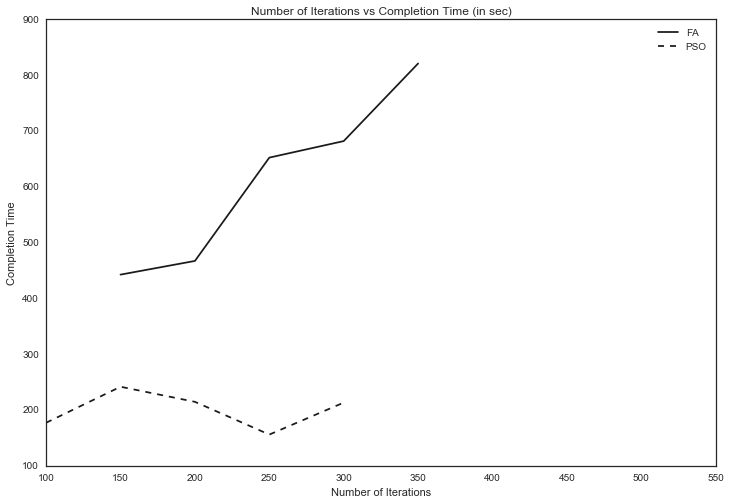

In [46]:
plt.figure(figsize=(12,8))
plt.plot(firefly_data.max_iter, firefly_data.finish_time, '-', label="FA",c="0.1")
plt.plot(pso_data.max_iter, pso_data.finish_time, '--', label="PSO",c="0.1")
plt.title("Number of Iterations vs Completion Time (in sec)")
plt.legend()
plt.xlim([100,550])
plt.xlabel("Number of Iterations")
plt.ylabel("Completion Time")
plt.savefig(filename="iteration_time.jpg",bbox_inches='tight')

In [41]:
# import math
# rmse_pso = math.sqrt(calculate_mse(weights))
pso_data['error'][3]

0.69844934618881604

In [42]:
firefly_weights = [1.68025248e-01,   6.33696638e-01,
          1.66857644e-01,   9.56715600e-01,   1.40681305e-02,
          5.67212948e-01,   1.00000000e+00,   6.86592048e-02,
          5.79232355e-01,   1.61788904e-01,   4.37825980e-01,
          3.69704405e-01,   0.00000000e+00,   4.01681141e-03,
          8.79106525e-01,   1.00000000e+00,   1.05052174e-01,
          1.07819948e-01,   2.72514379e-01,   3.28510792e-01,
          6.13944565e-01,   9.51533687e-02,   4.47570215e-01,
          1.30900553e-01,   2.16290656e-01,   6.44635553e-01,
          5.39704064e-01,   3.07633150e-01,   4.08444731e-01,
          1.21906170e-01,   8.90305749e-01,   7.84412855e-01,
          1.27553341e-02,   3.72605965e-01,   1.00000000e+00,
          9.32838295e-01,   4.78820245e-02,   5.38214725e-01,
          1.17678254e-01,   8.90642164e-01,   9.63329961e-01,
          5.95070050e-01,   1.71280877e-01,   8.36161037e-01,
          8.92182043e-01,   8.49683813e-01,   7.79639685e-01,
          4.30269157e-01,   1.47509001e-01,   6.26900403e-01,
          0.00000000e+00,   1.85521377e-01,   0.00000000e+00,
          8.12236457e-01,   3.09164602e-01,   9.12206287e-01,
          1.30752794e-01,   6.50837607e-01,   7.96365160e-01,
          2.73648179e-01,   7.36400471e-01,   0.00000000e+00,
          8.11443812e-01,   2.90960605e-01,   5.66172405e-01,
          2.83946883e-01,   1.93584952e-02,   0.00000000e+00,
          7.15086381e-01,   1.55208457e-01,   3.60413957e-01,
          1.00000000e+00,   1.36068943e-01,   5.51236193e-01]
pso_weights = [6.991025340806624744e-01,6.864600601424905024e-01,4.577271812056464828e-01,6.149641724232440820e-01,9.233228441591770919e-01,1.472056226177070534e-02,8.430557787731045583e-01,6.751057965208809852e-01,9.911109797898056684e-01,3.862303349207192871e-01,0.000000000000000000e+00,1.036704318254458052e-04,2.173106328552092403e-01,5.726397444991686569e-01,0.000000000000000000e+00,3.643106146455452610e-01,6.817808724091881656e-01,8.239947398097096087e-01,8.677191086806317344e-01,1.544605817412877669e-01,5.341773493326725797e-01,1.983626238302186250e-04,1.000000000000000000e+00,2.262375227399178804e-02,0.000000000000000000e+00,3.032814779006614558e-01,5.493174581777889864e-01,3.710592650635394785e-01,2.078290345498789993e-02,6.119626618786409011e-01,0.000000000000000000e+00,0.000000000000000000e+00,6.299069535185680691e-01,6.357850800082401888e-01,6.654054099204487205e-01,6.216289028085781460e-02,8.997043478538357952e-01,4.735720257070915595e-01,2.573173267430859945e-01,3.043953400517680485e-01,7.185977794447576672e-01,1.637464352945744439e-02,3.458274241513435432e-01,1.109355051208655261e-02,6.170920155398555984e-01,5.763464806065040635e-01,5.835127099390990946e-01,2.480718849071708865e-01,1.815783140317607791e-01,9.475015416394066969e-01,7.692050348184397695e-06,6.593428423157277063e-01,3.866610975531077909e-01,8.269520957416945928e-01,4.555524577485187132e-01,4.555217118352588024e-01,6.654185311852937046e-01,6.778156336804584958e-01,4.849310694210372842e-06,6.341067771092458692e-03,6.907898250408722740e-02,1.968814704515519376e-01,1.888917821851804901e-01,1.000000000000000000e+00,4.880525609153650857e-01,7.984339061873557686e-02,0.000000000000000000e+00,1.586031845535752771e-01,0.000000000000000000e+00,9.192661670781081540e-01,7.055951888894982336e-03,4.910685979937167156e-01,2.679131244364733599e-01,1.161900433009498551e-01]

In [45]:
import math
rmse_pso = math.sqrt(calculate_mse(pso_weights))
rmse_firefly = math.sqrt(calculate_mse(firefly_weights))

ValueError: shapes (74,) and (261,) not aligned: 74 (dim 0) != 261 (dim 0)

In [ ]:
# ax = plt.axes()
# plt.bar([1,2], [rmse_pso,rmse_firefly], width=0.2, label=['pso','firefly'],align='center')
# plt.xlim([0,3])
# plt.ylim([0,3])
# # plt.tick_params(
# #     axis='x',          # changes apply to the x-axis
# #     which='both',      # both major and minor ticks are affected
# #     bottom='off',      # ticks along the bottom edge are off
# #     top='off',         # ticks along the top edge are off
# #     labelbottom='off')
# ax.set_xticks(x)
# ax.set_xticklabels(['PSO', 'Firefly'])
# plt.legend()

In [ ]:
import pylab
x = [1,1.6]
y = [rmse_pso,rmse_firefly]
f = pylab.figure(figsize=(12,8))
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(x, y, align='center',width=0.2, color="black")
ax.set_xticks(x)
ax.set_xticklabels(['PSO','Firefly'])
ax.set_xlim([0.5,2])
ax.set_ylim([0,3])
ax.set_title("RMSE comparison between PSO and FA.")
f.savefig(filename="Rmse_comparison.jpg",bbox_inches='tight')

In [47]:
rmse_pso, rmse_firefly

NameError: name 'rmse_pso' is not defined